In [ ]:
!pip install pwlf
!pip install git+https://github.com/chasmani/piecewise-regression
!apt install imagemagick

  Created wheel for pwlf: filename=pwlf-2.2.1-py3-none-any.whl size=16609 sha256=ca26fdeae95aa7292928e644eb628dc88717cd114fe15002a2f493d870b94f3a
  Stored in directory: /root/.cache/pip/wheels/2d/71/b9/a5f72e5ebcb7538f085c07fc6ab888057508655fe4c161cce9
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=9b871118e8e7e592164958ae69f3eda054f58918d9526921d878e07d5ee3e91e
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pwlf pyDOE
  Cloning https://github.com/chasmani/piecewise-regression to /tmp/pip-req-build-4wej_sr_
  Running command git clone -q https://github.com/chasmani/piecewise-regression /tmp/pip-req-build-4wej_sr_
  Created wheel for piecewise-regression: filename=piecewise_regression-1.2.1-py3-none-any.whl size=24327 sha256=66431624bc782d5ff842db2e2367dbf944199b604e7f4f03dd1581ba337e1c61
  Stored in directory: /tmp/pip-ephem-wheel-cache-_yqrys1s/wheels/6d/40/e7/3f8f2453fcc

In [ ]:
from sklearn import linear_model
from scipy.optimize import curve_fit
from scipy.optimize import nnls
import cvxpy as cp
import numpy as np
import scipy as sp
# import dykstra 
import matplotlib.pyplot as plt
# import pwlf
import matplotlib.animation as animation
from matplotlib import rc

rc('animation', html='jshtml')

# Setting and Hyperparameters

In [ ]:
valuations = np.array([[33.20073227,42.15295504,27.84166366,24.64496075,14.18682877],
 [46.24081565,15.81069026,42.19555825,11.14477395,42.42584702]])

# Library

## utilities

In [ ]:
###################################################
def normalize_vector(vector):
    return (vector / np.sum(vector).clip(0.01))



################### Utility Functions ##########################

def get_linear_util(demands, valuations):
    util = np.sum(demands * valuations, axis = 1) 
    return util


def get_leontief_util(demands, valuations):
    util =  np.min(demands/valuations.clip(min = 0.001), axis = 1)
    return util

def get_cd_util(demands, valuations):
    util = np.sum(np.log(demands.clip(min = 0.001))*valuations, axis = 1) 
    return normalize_vector(util)



#################### Utility Gradient Functions #####################
def get_linear_util_gradient(allocations, valuations):
    return valuations

def get_leontief_util_gradient(allocations, valuations):
    grad_matrix = []
    argmins = np.argmin(allocations/valuations.clip(min = 0.001), axis = 0)
    marginal_utils = np.zeros(allocations.shape)
    
    for buyer in range(allocations.shape[0]):
      marginal_utils[buyer, argmins[buyer] ] = 1 / valuations[buyer, argmins[buyer]].clip(min = 0.001)
    
    return marginal_utils

def get_cd_util_gradient(allocations, valuations):
    # return ( np.prod(np.power(allocations, valuations), axis = 1)*( valuations / allocations.clip(min = 0.001) ).T).T
    return normalize_vector(( valuations / allocations.clip(min = 0.001) ))
################### Projection Onto Budget Set ##########################


def project_onto_half_space(X, beta, p, b):
  offsets = ((X @ p + beta - b).clip(min= 0))/(np.linalg.norm(p)**2).clip(min= 10e-5)

  X_proj = X - (offsets*np.tile(p, reps = (b.shape[0], 1)).T).T
  beta_proj = beta - offsets
  
  return (X_proj, beta_proj)


def project_onto_positive_ortanth(X, beta, p, b):

  return (X.clip(min = 0), beta.clip(min = 0))

def project_to_bugdet_set(X, beta, p, b):
  iter = 0
  P_X, P_beta = np.zeros(X.shape), np.zeros(b.shape[0])
  Q_X, Q_beta = np.zeros(X.shape), np.zeros(b.shape[0])
  X_proj_y, beta_proj_y = X, beta
  X_proj_x, beta_proj_x = np.ones(X.shape), np.ones(b.shape[0])
  
  X_proj_prev, beta_proj_prev = X.copy(), beta.copy()
  change = float("inf")
  iter = 0
  # while np.any(X_proj_x @ p + beta_proj_x - b >  10e-4) or np.any(X_proj_x < 0) or np.any(beta_proj_x < 0) :
  while iter <= 500:
    iter += 1
    # print("iterations", iter, "error: ", change)
    X_proj_x, beta_proj_x = project_onto_positive_ortanth(X_proj_y + P_X, beta_proj_y + P_beta, p, b)
    # print("proj", X_proj_x, beta_proj_x)
    P_X, P_beta = (P_X + X_proj_y - X_proj_x, P_beta + beta_proj_y - beta_proj_x)
    X_proj_y, beta_proj_y = project_onto_half_space(X_proj_x + Q_X, beta_proj_x + Q_beta, p, b)
    Q_X, Q_beta = Q_X + X_proj_x - X_proj_y, Q_beta + beta_proj_x- beta_proj_y
    
    change = np.linalg.norm(X_proj_prev - X_proj_x) + np.linalg.norm(beta_proj_prev - beta_proj_x)
    X_proj_prev, beta_proj_prev = X_proj_x.copy(), beta_proj_x.copy()
    # X, beta = project_onto_positive_ortanth(X, beta, p, b )
    # X, beta = project_onto_half_space(X, beta, p, b )
  
  # assert np.all(X_proj_x @ p + beta_proj_x - b <=  10e-2) and np.all(X_proj_x >= 0) and np.all(beta_proj_x >= 0) 
  # print("proj", X_proj_x, beta_proj_x)
  return X_proj_x, beta_proj_x
  # shadow_demands = np.zeros((X.shape[0], X.shape[1] + 1))
  # shadow_prices = np.zeros(X.shape[1] + 1)
  # shadow_demands[:, :-1] = X 
  # shadow_demands[:, -1] = beta

  # shadow_prices[:-1] = p
  # shadow_prices[-1] = 1
  
  # P, Q = np.zeros((X.shape[0], X.shape[1] + 1))
  # (1/np.linalg.norm(shadow_prices)**2).clip(min= 0.00000001)*((shadow_demands @ shadow_prices - b).clip(min= 0)* np.tile(shadow_prices, reps = (b.shape[0], 1)).T).T
  # while (np.linalg.norm((shadow_demands @   shadow_prices - b).clip(min = 0)) < 1):
      
  #     shadow_demands -= (1/np.linalg.norm(shadow_prices)**2).clip(min= 0.00000001)*((shadow_demands @ shadow_prices - b).clip(min= 0)* np.tile(shadow_prices, reps = (b.shape[0], 1)).T).T
  #     shadow_demands = shadow_demands.clip(min = 0)
      
  
  
  # return (shadow_demands[:, :-1], shadow_demands[:, -1])

################### Min-Max Objective Functions ##########################

def get_linear_obj(prices, demands, budgets, valuations):
  utils = np.sum(valuations * demands, axis = 1)
  return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


def get_leontief_obj(prices, demands, budgets, valuations):
    utils = np.min(demands/valuations, axis = 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


def get_cd_obj(prices, demands, budgets, valuations):
    utils = np.prod(np.power(demands, valuations), axis= 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


################### Heuristic objective function ##########################
def get_global(X, get_obj, prices, budgets, valuations, value_coef, value_intercept):
  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  X = X.reshape((num_buyers, num_goods + 1))
  
  demands = X[:, :-1]
  savings = X[:, -1]
  demands = demands.clip(min = 0.0001)
  savings = savings.clip(min = 0.0001)
  
  return -(get_obj(prices, demands, budgets-savings, valuations) + discount*(value_coef.T @ savings + value_intercept) )

## get_max

In [ ]:
def get_max_linear(b, valuation, p, gamma, slopes, intercepts):
    allocation = cp.Variable(p.shape[0])
    saving = cp.Variable()
    
    obj = cp.Maximize(valuation.T @ allocation + gamma*(slopes*saving+intercepts))
    constr = [allocation.T @ p  + saving <= b,
                allocation >= 0,
                saving >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value
    saving = saving.value

    return (util, demand, saving)

def get_max_leontief(b, valuation, p, gamma, slopes, intercepts):
    allocation = cp.Variable(p.shape[0])
    saving = cp.Variable()
    
    obj = cp.Maximize(cp.min(allocation / valuation) + gamma*(slopes * saving + intercepts))
    constr = [allocation.T @ p  + saving <= b,
                allocation >= 0,
                saving >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value
    saving = saving.value

    return (util, demand, saving)


def get_max_cd(b, valuation, p, gamma, slopes, intercepts):
    allocation = cp.Variable(p.shape[0])
    saving = cp.Variable()
    
    obj = cp.Maximize(valuation.T @ cp.log(allocation) + gamma*(slopes*saving+intercepts))
    constr = [allocation.T @ p  + saving <= b,
                allocation >= 0,
                saving >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value
    saving = saving.value

    return (util, demand, saving)


# def get_max_linear(b, valuation, p, gamma, slope, intercept):
#     allocation = cp.Variable(p.shape[0])
#     saving = cp.Variable()
    
#     obj = cp.Maximize(valuation.T @ allocation + gamma*(slope*saving+intercept))
#     constr = [allocation.T @ p  + saving <= b,
#                 allocation >= 0,
#                 saving >= 0]
#     program = cp.Problem(obj, constr)

#     util = program.solve()
#     demand = allocation.value
#     saving = saving.value

#     return (util, demand, saving)

# def get_max_leontief(b, valuation, p, gamma, slope, intercept):
#     allocation = cp.Variable(p.shape[0])
#     saving = cp.Variable()
    
#     obj = cp.Maximize(cp.min(allocation / valuation) + gamma*(slope * saving + intercept))
#     constr = [allocation.T @ p  + saving <= b,
#                 allocation >= 0,
#                 saving >= 0]
#     program = cp.Problem(obj, constr)

#     util = program.solve()
#     demand = allocation.value
#     saving = saving.value

#     return (util, demand, saving)


# def get_max_cd(b, valuation, p, gamma, slope, intercept):
#     allocation = cp.Variable(p.shape[0])
#     saving = cp.Variable()
    
#     obj = cp.Maximize(valuation.T @ cp.log(allocation) + gamma*(slope*saving+intercept))
#     constr = [allocation.T @ p  + saving <= b,
#                 allocation >= 0,
#                 saving >= 0]
#     program = cp.Problem(obj, constr)

#     util = program.solve()
#     demand = allocation.value
#     saving = saving.value

#     return (util, demand, saving)

## get_optimal_value_function_singlebuyer

In [ ]:
# Value iteration on single buyer to get optimal value function
def get_optimal_value_function_singlebuyer(valuation, p, gamma, slopes, intercepts, num_iters, num_samples, utility_type):

    global error_count

    if utility_type == "linear":
        get_max = get_max_linear
    elif utility_type == "leontief":
        get_max = get_max_leontief
    elif utility_type == "cd":
        get_max = get_max_cd


    # Initialize the convex program get_max
    allocation = cp.Variable(p.shape)
    saving = cp.Variable()
    b = cp.Parameter(nonneg=True)
    value_slopes = cp.Parameter(3)
    value_intercepts = cp.Parameter(3)

    linear_obj = cp.Maximize(valuation.T @ allocation + gamma*(value_slopes*saving + value_intercepts))
    leontief_obj = cp.Maximize(cp.min(allocation / valuation) + gamma*(value_slopes*saving + value_intercepts))
    cd_obj = cp.Maximize(valuation.T @ cp.log(allocation) + gamma*(value_slopes*saving + value_intercepts))
    constr = [allocation.T @ p  + saving <= b,
                allocation >= 0,
                saving >= 0]
    if utility_type == "linear":
        obj = linear_obj
    elif utility_type == "leontief":
        obj = leontief_obj
    elif utility_type == "cd":
        obj = cd_obj
    prob = cp.Problem(obj, constr)


    value_slopes.value = slopes
    value_intercepts.value = intercepts

    # value_slopes = slopes
    # value_intercepts = intercepts

    # Start the value iteration
    for iter in range(num_iters):
        if iter % 10 == 0:
            print(f"Iteration {iter}/{num_iters}")

        values = []
        budgets = np.random.uniform(0,1, num_samples)

        for budget in budgets:
            # Solve the convex program repeatedly
            b.value = budget
            try:
              util = prob.solve(solver="ECOS")
            except cp.SolverError:
              error_count = error_count + 1
              print(f"There is an ERROR!! It's the NO. {error_count} error!")

            # util, demand, saving = get_max(budget, valuation, p, discount, value_slopes, value_intercepts)
            values.append(util)
        
        reg = linear_model.LinearRegression()
        reg.fit(np.array(budgets).reshape(-1,1), np.array(values))
        value_slopes = reg.coef_ # Update the slope
        value_intercepts = reg.intercept_ # Update the intercept


    
    return value_slopes.value, value_intercepts.value

## min-max step

In [ ]:
def min_max_linear_value_cvx_project(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                         num_iters_prices, num_iters_demands, utility_type):
  prices = np.zeros(valuations.shape[1]).clip(min=0.1)
  # print(f"valuations: {valuations}")
  if utility_type == "linear":
      get_util = get_linear_util
      get_marginal_util = get_linear_util_gradient
      get_obj = get_linear_obj

  elif utility_type == "leontief":
      get_util = get_leontief_util
      get_marginal_util = get_leontief_util_gradient
      get_obj = get_leontief_obj

  elif utility_type == "cd":
      get_util = get_cd_util
      get_marginal_util = get_cd_util_gradient
      get_obj = get_cd_obj
      

  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  
  allocation = cp.Variable((num_buyers, num_goods))
  saving = cp.Variable(num_buyers)
  p = cp.Parameter(num_goods)
  b = cp.Parameter(num_buyers)  
  beta = cp.Parameter(num_buyers) 
  X = cp.Parameter((num_buyers, num_goods))

  obj = cp.Minimize( cp.sum(cp.power(cp.norm(X - allocation, axis = 1), 2)) + cp.sum(cp.power(saving - beta, 2)))
  # obj = cp.Minimize( cp.sum(cp.norm(X - allocation, axis = 1)) + cp.norm(saving - beta, 2))
  constr = [allocation @ p  + saving <= b,
              allocation >= 0,
              saving >= 0] 
  
  
  # Gradient Descent loop
  for iter_outer in range(1, num_iters_prices):
    if not(iter_outer % 10):
      print(f"\n****Min-Max Price Iteration {iter_outer}****")
   
    demands = np.zeros((num_buyers, num_goods)).clip(min = 1)
    savings = np.zeros(num_buyers).clip(min = 1)
    # Gradient Ascent loop
  
    for iter_inner in range(1, num_iters_demands):
      utils = get_util(demands, valuations).clip(min = 0.01)
      marginals = get_marginal_util(demands, valuations)
      spendings = budgets - savings
      
      # Demand step
      demands_step = (((spendings/utils)*marginals.T)).T
      demands += (iter_inner** (-1/2)) * learn_rate_demands*demands_step
      # demands += learn_rate_demands*demands_step
      
      # Saving step
      # savings +=  learn_rate_demands*( - np.log(utils) + discount*value_coef)
      savings += (iter_inner** (-1/2)) * learn_rate_demands*( - np.log(utils) + discount*value_coef)
      # savings += (iter_inner** (-1/2)) * learn_rate_demands*(discount*value_coef)
      
      # Projection step
      p.value = prices
      b.value = budgets
      beta.value = savings
      X.value = demands

      problem = cp.Problem(obj, constr)
      result = problem.solve(solver=cp.ECOS, warm_start=True)
      # print("problem status", problem.status)
      
      if (allocation.value is None):
        print("------------we got something wrong!!!----------------")
        print(f"utils: {utils}")
        print(f"obj: {result}")
        print(f"prices: {prices}")
        print(f"budgets:{budgets}")
        print(f"savings: {savings}")
        print(f"demands: {demands}")
      demands, savings = allocation.value, saving.value
      # demands, savings = project_to_bugdet_set(demands, savings, prices, budgets)
     

    assert np.all(demands @ prices + savings <= budgets + 10e-2)
    # print("before update prices:",prices)
    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    if np.linalg.norm(excess_demands)**2 < 10e-2:
      print("Early end! Excess demand norm:", np.linalg.norm(excess_demands)**2)
      break
    # if not(iter_outer % 10):
    #   print(f"\n****Min-Max Price Iteration {iter_outer}****")
    #   print(f"Prices:\n {prices}")
    #   print("demands:", demands)
    #   print("savings:", savings)
    #   print("budgets:", budgets)
    #   print(f"Excess Demands\n {excess_demands}")
    # prices += (iter_outer**(-1/2))*learn_rate_prices * excess_demands/(np.linalg.norm(excess_demands) + 10e-7)
    prices += learn_rate_prices * excess_demands/(np.linalg.norm(excess_demands) + 10e-7)

    
    # prices *= np.exp(learn_rate_prices*excess_demands/np.linalg.norm(excess_demands))
    # prices /= np.sum(budgets - savings)
    prices = np.clip(prices, a_min=0.001, a_max = None)

  value = get_obj(prices, demands, budgets-savings, valuations) + discount*(savings.T @ value_coef + value_intercept)
  return value, prices, demands, savings





def min_max_linear_value_heuristic(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                         num_iters_prices, num_iters_demands, utility_type):
  prices = np.zeros(valuations.shape[1]).clip(min=1/np.sum(budgets))
  print(f"valuations: {valuations}")
 
  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  
 
  if utility_type == "linear":
      get_util = get_linear_util
      get_marginal_util = get_linear_util_gradient
      get_obj = get_linear_obj


  elif utility_type == "leontief":
      get_util = get_leontief_util
      get_marginal_util = get_leontief_util_gradient
      get_obj = get_leontief_obj
      

  elif utility_type == "cd":
      get_util = get_cd_util
      get_marginal_util = get_cd_util_gradient
      get_obj = get_cd_obj

  allocation = cp.Variable((num_buyers, num_goods))
  saving = cp.Variable(num_buyers)
  p = cp.Parameter(num_goods)
  beta = cp.Parameter(num_buyers) 
  X = cp.Parameter((num_buyers, num_goods))

  obj = cp.Minimize( cp.sum(cp.power(cp.norm(X - allocation, axis = 1), 2)) + cp.sum(cp.power(saving - beta, 2)))
  constr = [allocation @ p  + saving <= budgets,
              allocation >= 0,
              saving >= 0] 
  
  # Gradient Descent loop
  for iter_outer in range(1, num_iters_prices):
    if not(iter_outer % 10):
      print(f"\n**Min-Max Price Iteration {iter_outer}**")
    # get_global(X, get_obj, prices, budgets, valuations, value_coef, value_intercept)
    ranges = tuple((0.01, max(np.max(budgets)/np.min(prices).clip(min = 0.01), 0.02)) for i in range(num_buyers*(num_goods+1)))
    # print(ranges)
    
    resbrute = sp.optimize.dual_annealing(get_global, ranges, args = (get_obj, prices, budgets, valuations, value_coef, value_intercept))
    results = resbrute.x.reshape((valuations.shape[0], valuations.shape[1] + 1))
    demands = results[:, :-1]
    savings = results[:, -1]

    demands = demands.clip(min = 0.0001)
    savings = savings.clip(min = 0.0001)
    # Projection step
    p.value = prices
    beta.value = savings
    X.value = demands

    problem = cp.Problem(obj, constr)
    problem.solve(warm_start=True)
    # print("problem status", problem.status)
    demands, savings = allocation.value, saving.value
    # print("demands brute", demands)
    # print("savings", savings)

    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    if np.linalg.norm(excess_demands)**2 < 10e-2:
      print("Early end! Excess demand norm:", np.linalg.norm(excess_demands)**2)
      break
    prices += (iter_outer**(-1/2))*learn_rate_prices*excess_demands/np.linalg.norm(excess_demands)
    # prices /= np.sum(budgets - savings)  
    prices = np.clip(prices, a_min=0.000001, a_max = None)

    # if not(iter_outer % 10):
    #   print(f"\n**Min-Max Price Iteration {iter_outer}**")
    #   print(f"Prices:\n {prices}")
    #   print(f"Excess Demands\n {excess_demands}")
    #   print(f"actual spending\n {demands @ prices}")
    #   print(f"spending\n {budgets - savings}")
  
  # print(f"Prices:\n {prices}")
  # print(f"Excess Demands\n {excess_demands}")
  # print(f"Savings:\n {savings}")
  # print(f"actual spending\n {demands @ prices}")
  # print(f"spending\n {budgets - savings}")
  
  value = get_obj(prices, demands, budgets-savings, valuations) + discount*(savings.T @ value_coef + value_intercept)
  return value, prices, demands, savings

## get_greedy_action

In [ ]:
def get_greedy_action_cvx(budgets, valuations, utility_type, value_coef, value_intercept, discount, 
                      learn_rate_prices, learn_rate_demands, num_iters_prices, num_iters_demands):

  value, prices, allocations, savings = min_max_linear_value_cvx_project(budgets, valuations, value_coef, value_intercept, discount, 
                                                             learn_rate_prices, learn_rate_demands, num_iters_prices, num_iters_demands, 
                                                             utility_type)

  return (prices, allocations, savings)


def get_greedy_action_heuristic(budgets, valuations, utility_type, value_coef, value_intercept, discount, 
                      learn_rate_prices, learn_rate_demands, num_iters_prices, num_iters_demands):

  value, prices, allocations, savings = min_max_linear_value_heuristic(budgets, valuations, value_coef, value_intercept, discount, 
                                                             learn_rate_prices, learn_rate_demands, num_iters_prices, num_iters_demands, 
                                                             utility_type)

  return (prices, allocations, savings)

## get_buyers_cumulative_util

In [ ]:
def get_buyers_cumulative_util_cvx(init_budgets, valuations, utility_type, value_coef, value_intercept, discount, learn_rate_prices, 
                               learn_rate_demands, num_iters_prices, num_iters_demands, num_iters):
  
  if utility_type == "linear":
      get_util = get_linear_util
  
  elif utility_type == "leontief":
      get_util = get_leontief_util
  
  elif utility_type == "cd":
      get_util = get_cd_util
  
  num_buyers = valuations.shape[0]
  num_goods = valuations.shape[1]
  cumul_utils = np.zeros(num_buyers)
  excess_demands_hist = []
  budgets = init_budgets   
  for iter in range(1, num_iters):
    print(f"--------------------cumulative iter {iter}---------------------")
    prices, allocations, savings = get_greedy_action_cvx(budgets, valuations, utility_type, value_coef, value_intercept, discount, 
                                                     learn_rate_prices, learn_rate_demands, num_iters_prices, num_iters_demands)
    excess_demands = np.sum(allocations, axis = 0) - np.ones(num_goods)
    excess_demands_hist.append(np.linalg.norm(excess_demands))
    if iter==1:
      start_prices = prices
    cumul_utils += (discount**iter)*get_util(allocations, valuations)
    budgets = savings

  return start_prices, cumul_utils, excess_demands_hist






def get_buyers_cumulative_util_heuristic(init_budgets, valuations, utility_type, value_coef, value_intercept, discount, learn_rate_prices, 
                               learn_rate_demands, num_iters_prices, num_iters_demands, num_iters):
  
  if utility_type == "linear":
      get_util = get_linear_util
  
  elif utility_type == "leontief":
      get_util = get_leontief_util
  
  elif utility_type == "cd":
      get_util = get_cd_util
  
  num_buyers = valuations.shape[0]
  num_goods = valuations.shape[1]
  cumul_utils = np.zeros(num_buyers)
  excess_demands_hist = []
  budgets = init_budgets   
  for iter in range(1, num_iters):
    print(f"--------------------cumulative iter {iter}---------------------")
    prices, allocations, savings = get_greedy_action_heuristic(budgets, valuations, utility_type, value_coef, value_intercept, discount, 
                                                     learn_rate_prices, learn_rate_demands, num_iters_prices, num_iters_demands)
    excess_demands = np.sum(allocations, axis = 0) - np.ones(num_goods)
    excess_demands_hist.append(np.linalg.norm(excess_demands))
    if iter==1:
      start_prices = prices
    cumul_utils += (discount**iter)*get_util(allocations, valuations)
    budgets = savings

  return start_prices, cumul_utils, excess_demands_hist

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
utility_type = "linear"

coef_hist_cvx_filename = f"/content/drive/My Drive/old_exp_results/exp_results_{utility_type}_new_valfunc/coef_hist_{utility_type}_fisher.npy"
intercept_hist_cvx_filename = f"/content/drive/My Drive/old_exp_results/exp_results_{utility_type}_new_valfunc/intercept_hist_{utility_type}_fisher.npy"
values_hist_cvx_filename = f"/content/drive/My Drive/old_exp_results/exp_results_{utility_type}_new_valfunc/values_hist_{utility_type}_fisher.npy"
budgets_hist_cvx_filename = f"/content/drive/My Drive/old_exp_results/exp_results_{utility_type}_new_valfunc/budgets_hist_{utility_type}_fisher.npy"

with open(coef_hist_cvx_filename, 'rb') as f:
    coef_hist_linear_cvx = np.load(f)
with open(intercept_hist_cvx_filename, 'rb') as f:
    intercept_hist_linear_cvx = np.load(f)
with open(values_hist_cvx_filename, 'rb') as f:
    values_hist_linear_cvx = np.load(f)
with open(budgets_hist_cvx_filename, 'rb') as f:
    budgets_hist_linear_cvx = np.load(f)

coef_hist_heuristic_filename = f"/content/drive/My Drive/old_exp_results/exp_results_2/coef_hist_{utility_type}_fisher_heuristic.npy"
intercept_hist_heuristic_filename = f"/content/drive/My Drive/old_exp_results/exp_results_2/intercept_hist_{utility_type}_fisher_heuristic.npy"
values_hist_heuristic_filename = f"/content/drive/My Drive/old_exp_results/exp_results_2/values_hist_{utility_type}_fisher_heuristic.npy"
budgets_hist_heuristic_filename = f"/content/drive/My Drive/old_exp_results/exp_results_2/budgets_hist_{utility_type}_fisher_heuristic.npy"

with open(coef_hist_heuristic_filename, 'rb') as f:
    coef_hist_linear_heuristic = np.load(f)
with open(intercept_hist_heuristic_filename, 'rb') as f:
    intercept_hist_linear_heuristic = np.load(f)
with open(values_hist_heuristic_filename, 'rb') as f:
    values_hist_linear_heuristic = np.load(f)
with open(budgets_hist_heuristic_filename, 'rb') as f:
    budgets_hist_linear_heuristic = np.load(f)

In [ ]:
utility_type = "leontief"

coef_hist_cvx_filename = f"/content/drive/My Drive/old_exp_results/exp_results_{utility_type}_new_valfunc/coef_hist_{utility_type}_fisher.npy"
intercept_hist_cvx_filename = f"/content/drive/My Drive/old_exp_results/exp_results_{utility_type}_new_valfunc/intercept_hist_{utility_type}_fisher.npy"
values_hist_cvx_filename = f"/content/drive/My Drive/old_exp_results/exp_results_{utility_type}_new_valfunc/values_hist_{utility_type}_fisher.npy"
budgets_hist_cvx_filename = f"/content/drive/My Drive/old_exp_results/exp_results_{utility_type}_new_valfunc/budgets_hist_{utility_type}_fisher.npy"

with open(coef_hist_cvx_filename, 'rb') as f:
    coef_hist_leontief_cvx = np.load(f)
with open(intercept_hist_cvx_filename, 'rb') as f:
    intercept_hist_leontief_cvx = np.load(f)
with open(values_hist_cvx_filename, 'rb') as f:
    values_hist_leontief_cvx = np.load(f)
with open(budgets_hist_cvx_filename, 'rb') as f:
    budgets_hist_leontief_cvx = np.load(f)

coef_hist_heuristic_filename = f"/content/drive/My Drive/old_exp_results/exp_results_2/coef_hist_{utility_type}_fisher_heuristic.npy"
intercept_hist_heuristic_filename = f"/content/drive/My Drive/old_exp_results/exp_results_2/intercept_hist_{utility_type}_fisher_heuristic.npy"
values_hist_heuristic_filename = f"/content/drive/My Drive/old_exp_results/exp_results_2/values_hist_{utility_type}_fisher_heuristic.npy"
budgets_hist_heuristic_filename = f"/content/drive/My Drive/old_exp_results/exp_results_2/budgets_hist_{utility_type}_fisher_heuristic.npy"

with open(coef_hist_heuristic_filename, 'rb') as f:
    coef_hist_leontief_heuristic = np.load(f)
with open(intercept_hist_heuristic_filename, 'rb') as f:
    intercept_hist_leontief_heuristic = np.load(f)
with open(values_hist_heuristic_filename, 'rb') as f:
    values_hist_leontief_heuristic = np.load(f)
with open(budgets_hist_heuristic_filename, 'rb') as f:
    budgets_hist_leontief_heuristic = np.load(f)

In [ ]:
utility_type = "cd"

coef_hist_cvx_filename = f"/content/drive/My Drive/old_exp_results/exp_results_{utility_type}_new_valfunc/coef_hist_{utility_type}_fisher.npy"
intercept_hist_cvx_filename = f"/content/drive/My Drive/old_exp_results/exp_results_{utility_type}_new_valfunc/intercept_hist_{utility_type}_fisher.npy"
values_hist_cvx_filename = f"/content/drive/My Drive/old_exp_results/exp_results_{utility_type}_new_valfunc/values_hist_{utility_type}_fisher.npy"
budgets_hist_cvx_filename = f"/content/drive/My Drive/old_exp_results/exp_results_{utility_type}_new_valfunc/budgets_hist_{utility_type}_fisher.npy"

with open(coef_hist_cvx_filename, 'rb') as f:
    coef_hist_cd_cvx = np.load(f)
with open(intercept_hist_cvx_filename, 'rb') as f:
    intercept_hist_cd_cvx = np.load(f)
with open(values_hist_cvx_filename, 'rb') as f:
    values_hist_cd_cvx = np.load(f)
with open(budgets_hist_cvx_filename, 'rb') as f:
    budgets_hist_cd_cvx = np.load(f)

coef_hist_heuristic_filename = f"/content/drive/My Drive/old_exp_results/exp_results_2/coef_hist_{utility_type}_fisher_heuristic.npy"
intercept_hist_heuristic_filename = f"/content/drive/My Drive/old_exp_results/exp_results_2/intercept_hist_{utility_type}_fisher_heuristic.npy"
values_hist_heuristic_filename = f"/content/drive/My Drive/old_exp_results/exp_results_2/values_hist_{utility_type}_fisher_heuristic.npy"
budgets_hist_heuristic_filename = f"/content/drive/My Drive/old_exp_results/exp_results_2/budgets_hist_{utility_type}_fisher_heuristic.npy"

with open(coef_hist_heuristic_filename, 'rb') as f:
    coef_hist_cd_heuristic = np.load(f)
with open(intercept_hist_heuristic_filename, 'rb') as f:
    intercept_hist_cd_heuristic = np.load(f)
with open(values_hist_heuristic_filename, 'rb') as f:
    values_hist_cd_heuristic = np.load(f)
with open(budgets_hist_heuristic_filename, 'rb') as f:
    budgets_hist_cd_heuristic = np.load(f)

# Changes in Value Functions

## Plot

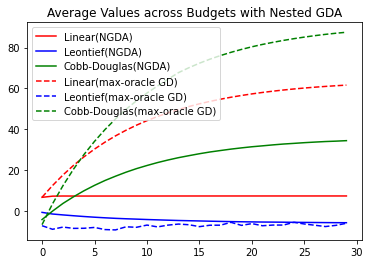

In [ ]:
avg_values_linear_cvx = np.average(values_hist_linear_cvx, axis = 1)
avg_values_leontief_cvx = np.average(values_hist_leontief_cvx, axis = 1)
avg_values_cd_cvx = np.average(values_hist_cd_cvx, axis = 1)

fig, ax = plt.subplots()
ax.set_title('Average Values across Budgets with Nested GDA')
ax.plot(np.arange(0, avg_values_linear_cvx.shape[0]), avg_values_linear_cvx, 'r-',label = "Linear(NGDA)")
ax.plot(np.arange(0, avg_values_leontief_cvx.shape[0]), avg_values_leontief_cvx, 'b-', label = "Leontief(NGDA)")
ax.plot(np.arange(0, avg_values_cd_cvx.shape[0]), avg_values_cd_cvx, 'g-', label = "Cobb-Douglas(NGDA)")

avg_values_linear_heuristic = np.average(values_hist_linear_heuristic, axis = 1)
avg_values_leontief_heuristic = np.average(values_hist_leontief_heuristic, axis = 1)
avg_values_cd_heuristic = np.average(values_hist_cd_heuristic, axis = 1)

# fig, ax = plt.subplots()
# ax.set_title('Average Values across Budgets with Max-oracle GD')
ax.plot(np.arange(0, avg_values_linear_heuristic.shape[0]), avg_values_linear_heuristic, 'r--', label = "Linear(max-oracle GD)")
ax.plot(np.arange(0, avg_values_leontief_heuristic.shape[0]), avg_values_leontief_heuristic, 'b--', label = "Leontief(max-oracle GD)")
ax.plot(np.arange(0, avg_values_cd_heuristic.shape[0]), avg_values_cd_heuristic, 'g--', label = "Cobb-Douglas(max-oracle GD)")

ax.legend()
fig.show()


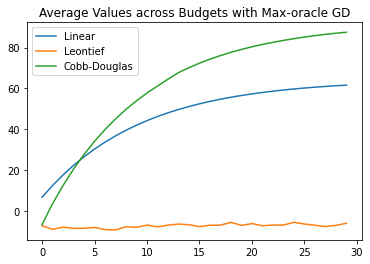

In [ ]:
avg_values_linear_heuristic = np.average(values_hist_linear_heuristic, axis = 1)
avg_values_leontief_heuristic = np.average(values_hist_leontief_heuristic, axis = 1)
avg_values_cd_heuristic = np.average(values_hist_cd_heuristic, axis = 1)

fig, ax = plt.subplots()
ax.set_title('Average Values across Budgets with Max-oracle GD')
ax.plot(np.arange(0, avg_values_linear_heuristic.shape[0]), avg_values_linear_heuristic, label = "Linear")
ax.plot(np.arange(0, avg_values_leontief_heuristic.shape[0]), avg_values_leontief_heuristic, label = "Leontief")
ax.plot(np.arange(0, avg_values_cd_heuristic.shape[0]), avg_values_cd_heuristic, label = "Cobb-Douglas")
ax.legend()
fig.show()

# Distance to Utility Maximization

## Algorithms

In [ ]:
def distance_between_cumul_utils_cvx(initial_budgets, valuations, utility_type, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands,
                                 num_iters_prices, num_iters_demands, num_iters_cumul, num_iters_single, num_samples_single):
  num_buyers = valuations.shape[0]
  num_goods = valuations.shape[1]

  # Based on VI
  start_prices, cumul_utils_VI, excess_demands_hist = get_buyers_cumulative_util_cvx(initial_budgets, valuations, utility_type, 
                                                            value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                                                            num_iters_prices, num_iters_demands, num_iters_cumul)
  
  print(f"cumul_utils_VI: {cumul_utils_VI}")
  # Single buyer
  if utility_type == "linear":
    slopes = np.array([-5, -10, -20])
    intercepts = np.array([-10, 5, 0])
  else: 
    slopes = np.array([2, -1, 4])
    intercepts = np.array([2, -1, 4])

  cumul_utils_single = []
  for buyer in range(num_buyers):
    valuation = valuations[buyer]
    initial_budget = initial_budgets[buyer]
    optimal_value_slopes, optimal_value_intercepts = get_optimal_value_function_singlebuyer(valuation, start_prices, discount, slopes, 
                                                                                            intercepts, num_iters_single, num_samples_single, 
                                                                                            utility_type)
    print("value:", np.min(optimal_value_slopes * initial_budget + optimal_value_intercepts))
    cumul_utils_single.append(np.min(optimal_value_slopes * initial_budget + optimal_value_intercepts))

  print(f"cumul_utils_VI: {cumul_utils_VI}")
  print(f"cumul_utils_single: {cumul_utils_single}")
  print(f"distance: {np.linalg.norm(cumul_utils_VI - cumul_utils_single)}")
  print(f"excess_demands_hist: {excess_demands_hist}")
  return cumul_utils_VI, cumul_utils_single, np.linalg.norm(cumul_utils_VI - cumul_utils_single), excess_demands_hist





def distance_between_cumul_utils_heuristic(initial_budgets, valuations, utility_type, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands,
                                 num_iters_prices, num_iters_demands, num_iters_cumul, num_iters_single, num_samples_single):
  num_buyers = valuations.shape[0]
  num_goods = valuations.shape[1]

  # Based on VI
  start_prices, cumul_utils_VI, excess_demands_hist = get_buyers_cumulative_util_heuristic(initial_budgets, valuations, utility_type, 
                                                            value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                                                            num_iters_prices, num_iters_demands, num_iters_cumul)
  print(f"cumul_utils_VI: {cumul_utils_VI}")
  # Single buyer
  if utility_type == "linear":
    slopes = 0
    intercepts = 0
  else: 
    slopes = 0
    intercepts = 0

  cumul_utils_single = []
  for buyer in range(num_buyers):
    valuation = valuations[buyer]
    initial_budget = initial_budgets[buyer]
    optimal_value_slopes, optimal_value_intercepts = get_optimal_value_function_singlebuyer(valuation, start_prices, discount, slopes, 
                                                                                            intercepts, num_iters_single, num_samples_single, 
                                                                                            utility_type)
    print("value:", optimal_value_slopes * initial_budget + optimal_value_intercepts)
    cumul_utils_single.append(optimal_value_slopes * initial_budget + optimal_value_intercepts)
  
  print(f"cumul_utils_VI: {cumul_utils_VI}")
  print(f"cumul_utils_single: {cumul_utils_single}")
  print(f"distance: {np.linalg.norm(cumul_utils_VI - cumul_utils_single)}")
  print(f"excess_demands_hist: {excess_demands_hist}")
  return cumul_utils_VI, cumul_utils_single, np.linalg.norm(cumul_utils_VI - cumul_utils_single), excess_demands_hist

## Run cvx Experiments

In [ ]:
error_count = 0
num_goods = 5
num_buyers = 2
discount = 0.9



valuations = np.array([[33.20073227,42.15295504,27.84166366,24.64496075,14.18682877],
 [46.24081565,15.81069026,42.19555825,11.14477395,42.42584702]])
initial_budgets = np.repeat(1, num_buyers)

learn_rate_prices_linear = 0.5
learn_rate_demands_linear = 0.02
learn_rate_prices_leontief = 0.5
learn_rate_demands_leontief = 0.01
learn_rate_prices_cd = 0.5
learn_rate_demands_cd = 0.005

num_iters_VI = 30 #30
num_iters_prices = 30 #30
num_iters_demands = 100 #100
num_iters_cumul = 30 #30

num_iters_single = 50
num_samples_single = 100

distance_collection = []
excess_demands_collection = []
for utility_type in ["cd"]:
    print(f"---------------------------------------{utility_type}--------------------------------------------")

    if utility_type == "linear":
      learn_rate_prices = learn_rate_prices_linear
      learn_rate_demands = learn_rate_demands_linear
      value_coef = coef_hist_linear_cvx[-1]
      value_intercept = intercept_hist_linear_cvx[-1]
    elif utility_type == "leontief":
      learn_rate_prices = learn_rate_prices_leontief
      learn_rate_demands = learn_rate_demands_leontief
      value_coef = coef_hist_leontief_cvx[-1]
      value_intercept = intercept_hist_leontief_cvx[-1]
    elif utility_type == "cd":
      learn_rate_prices = learn_rate_prices_cd
      learn_rate_demands = learn_rate_demands_cd
      value_coef = coef_hist_cd_cvx[-1]
      value_intercept = intercept_hist_cd_cvx[-1]

    print(f"value_coef: {value_coef}")
    print(f"value_intercept: {value_intercept}")

    cumul_utils_VI, cumul_utils_single, distance, excess_demands_hist = distance_between_cumul_utils_cvx(initial_budgets, valuations, utility_type, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                                  num_iters_prices, num_iters_demands, num_iters_cumul, num_iters_single, num_samples_single)
    distance_collection.append(distance)
    excess_demands_collection.append(excess_demands_hist)

---------------------------------------cd--------------------------------------------
value_coef: [-6.93890574 -8.82787727]
value_intercept: 42.95544268301644
--------------------cumulative iter 1---------------------

****Min-Max Price Iteration 10****

****Min-Max Price Iteration 20****
--------------------cumulative iter 2---------------------

****Min-Max Price Iteration 10****

****Min-Max Price Iteration 20****
--------------------cumulative iter 3---------------------

****Min-Max Price Iteration 10****

****Min-Max Price Iteration 20****
--------------------cumulative iter 4---------------------

****Min-Max Price Iteration 10****

****Min-Max Price Iteration 20****
--------------------cumulative iter 5---------------------

****Min-Max Price Iteration 10****

****Min-Max Price Iteration 20****
--------------------cumulative iter 6---------------------

****Min-Max Price Iteration 10****

****Min-Max Price Iteration 20****
--------------------cumulative iter 7------------------

## Run heuristic Experiments

In [ ]:
error_count = 0
num_goods = 5
num_buyers = 2
discount = 0.9



valuations = np.array([[33.20073227,42.15295504,27.84166366,24.64496075,14.18682877],
 [46.24081565,15.81069026,42.19555825,11.14477395,42.42584702]])
initial_budgets = np.repeat(1, num_buyers)

learn_rate_prices_linear = 0.5
learn_rate_demands_linear = 0.8
learn_rate_prices_leontief = 0.5
learn_rate_demands_leontief = 0.8
learn_rate_prices_cd = 0.5
learn_rate_demands_cd = 0.8

num_iters_VI = 30 #30
num_iters_prices = 30 #30
num_iters_demands = 100 #100
num_iters_cumul = 30 #30

num_iters_single = 50
num_samples_single = 100

distance_collection = []
excess_demands_collection = []

# for utility_type in ["linear",  "leontief", "cd"]:
for utility_type in ["leontief"]:
    print(f"---------------------------------------{utility_type}--------------------------------------------")
    if utility_type == "linear":
      learn_rate_prices = learn_rate_prices_linear
      learn_rate_demands = learn_rate_demands_linear
      value_coef = coef_hist_linear_heuristic[-1]
      value_intercept = intercept_hist_linear_heuristic[-1]
    elif utility_type == "leontief":
      learn_rate_prices = learn_rate_prices_leontief
      learn_rate_demands = learn_rate_demands_leontief
      value_coef = coef_hist_leontief_heuristic[-1]
      value_intercept = intercept_hist_leontief_heuristic[-1]
    elif utility_type == "cd":
      learn_rate_prices = learn_rate_prices_cd
      learn_rate_demands = learn_rate_demands_cd
      value_coef = coef_hist_cd_heuristic[-1]
      value_intercept = intercept_hist_cd_heuristic[-1]

    print(f"value_coef: {value_coef}")
    print(f"value_intercept: {value_intercept}")

    cumul_utils_VI, cumul_utils_single, distance, excess_demands_hist = distance_between_cumul_utils_heuristic(initial_budgets, valuations, utility_type, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                                  num_iters_prices, num_iters_demands, num_iters_cumul, num_iters_single, num_samples_single)
    distance_collection.append(distance)
    excess_demands_collection.append(excess_demands_hist)

---------------------------------------leontief--------------------------------------------
value_coef: [-8.52766448 -8.61154306]
value_intercept: 2.555165422775554
--------------------cumulative iter 1---------------------
valuations: [[33.20073227 42.15295504 27.84166366 24.64496075 14.18682877]
 [46.24081565 15.81069026 42.19555825 11.14477395 42.42584702]]

**Min-Max Price Iteration 10**

**Min-Max Price Iteration 20**
Early end! Excess demand norm: 0.09756994032982229
--------------------cumulative iter 2---------------------
valuations: [[33.20073227 42.15295504 27.84166366 24.64496075 14.18682877]
 [46.24081565 15.81069026 42.19555825 11.14477395 42.42584702]]

**Min-Max Price Iteration 10**

**Min-Max Price Iteration 20**
--------------------cumulative iter 3---------------------
valuations: [[33.20073227 42.15295504 27.84166366 24.64496075 14.18682877]
 [46.24081565 15.81069026 42.19555825 11.14477395 42.42584702]]

**Min-Max Price Iteration 10**

**Min-Max Price Iteration 20*

In [ ]:
print(distance_collection)

[0.015254892880953157]


## Make the table

In [ ]:
import plotly.graph_objects as go

headerColor = 'grey'
rowEvenColor = 'lightgrey'
rowOddColor = 'white'

fig = go.Figure(data=[go.Table(
  header=dict(
    values=['<b>Utility Type</b>','<b>Cumulative Utility based on VI</b>','<b>Maximized cumulative Utility</b>',
            '<b>Distance to Utility Maximization</b>','<b>Normalized Distance to Utility Maximization</b>', 
            '<b>Distance to Market Clearance (Average Excess Demands)</b>'],
    line_color='darkslategray',
    fill_color=headerColor,
    align=['left','center'],
    font=dict(color='white', size=12)
  ),
  cells=dict(
    values=[
      ['Linear (Nested GDA)', 'Linear (Max-oracle GD)', 'Leontief (Nested GDA)', 'Leontief (Max-oracle GD)', 'Cobb-Douglas (Nested GDA)', 'Cobb-Douglas (Max-oracle GD)'],
      ['[96.11864217, 872.44457586]', 
       '[58.83670238, 65.37844446]', 
       '[0.01241015, 0.01197241]', 
       '[0.0044322, 0.00609951]', 
       '[-759048.31311689, -844533.23523943]', 
       '[-763010.21531314 -847841.51430998]'],
      ['[84.79659719559233, 90.3457392997638]',
       '[96.96171820101995, 106.36975094410113]',
       '[0.009253314180356959, 0.008070244600082384]',
       '[0.012505356366874554, 0.00961266013048025]',
       '[-5410.446761817995, -5757.897160340484]', 
       '[-5482.763563167677, -5790.554467234857]'],
      [782.1807839960541, 55.98038976844064, 
       0.005019216377258324, 0.008804435107563718, 
       1127614.3407095883, 1132650.7224766547],
       [6.312670581380343,0.3889393929909976,
        0.408792752480498,0.5581970083770711,
        142.71734067443717, 142.0356741620785],
      [1.51360722680293,2.1650851972578646,
       2.1885091150520655,2.178489762142351, 
       2.1892506104891303, 2.1697254289647336]],
    line_color='darkslategray',
    # 2-D list of colors for alternating rows
    fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor,rowEvenColor]*5],
    align = ['left', 'center'],
    font = dict(color = 'darkslategray', size = 11)
    ))
])

fig.show()


In [ ]:
util_vi = np.array([0.0044322, 0.00609951])
util_single = np.array( [0.012505356366874554, 0.00961266013048025])
print(np.linalg.norm(util_vi-util_single))
print(np.linalg.norm(util_vi-util_single) / np.linalg.norm(util_single))

0.008804435107563718
0.5581970083770711


## Make the Bar Plot

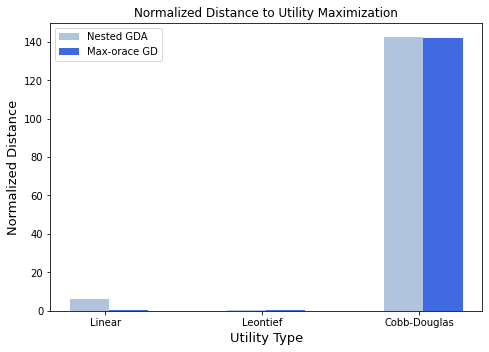

In [ ]:
data = [[6.312670581380343,0.408792752480498,142.71734067443717,],
[0.3889393929909976,0.5581970083770711,142.0356741620785]]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Normalized Distance to Utility Maximization')
ax.bar(X + 0.00, data[0], color = 'lightsteelblue', width = 0.25, label ='Nested GDA')
ax.bar(X + 0.25, data[1], color = 'royalblue', width = 0.25, label ='Max-orace GD')

plt.xlabel('Utility Type', fontsize = 13)
plt.xticks([r + 0.1 for r in range(3)],
        ['Linear', 'Leontief', 'Cobb-Douglas'])
plt.ylabel('Normalized Distance', fontsize = 13)


plt.legend()
plt.show()

# Distance to Market Clearance

In [ ]:
excess_demands_linear_cvx = np.array([1.007923199446748, 0.011324849082771498, 0.011398197315511347, 0.011431693362778687, 0.011514927297107215, 0.01157807542950712, 0.011618352406576533, 0.011679292163442259, 0.011766210726685216, 0.30914232888117826, 2.2360644706166517, 2.2360648322261607, 2.236064444420647, 2.2360666169808168, 2.2360638937796753, 2.2360653979793996, 2.23606707800732, 2.236067013359693, 2.2360665546967753, 2.236061975729724, 2.2360672219546243, 2.23606755935085, 2.2360675492441127, 2.2360658551356996, 2.2360676760900065, 2.236067971670458, 2.2360669689675574, 2.2360469023876464, 2.2360624685748447])
excess_demands_leontief_cvx = np.array([0.9293471161358905, 2.188377777310114, 2.229028680982791, 2.2315775449161825, 2.2327239919492086, 2.2335727449365246, 2.2342056502220706, 2.234674796050045, 2.2350239910558742, 2.235279193011836, 2.2354710987066877, 2.235620769377735, 2.235726979420378, 2.2358152237564304, 2.2358752833842446, 2.235923677364442, 2.235959152434828, 2.2359960362954117, 2.236017831284798, 2.236032348195055, 2.2360419838953502, 2.2360495106489986, 2.2360543575158216, 2.2360577367925876, 2.2360600743323733, 2.2360620043457797, 2.2360618811860014, 2.236063053510682, 2.236063847491746])
excess_demands_cd_cvx = np.array([0.878369719707621, 2.236067847485999, 2.2360677299612814, 2.236067670026975, 2.236067646686249, 2.236067924533268, 2.2360676432399735, 2.2360679257193556, 2.2360676419982752, 2.2360679249417434, 2.2360676417874736, 2.236067924783226, 2.2360676417662018, 2.2360679246573407, 2.2360676418047785, 2.236067924852683, 2.236067642098393, 2.2360679249652864, 2.2360676417504823, 2.236067925625168, 2.236067641510322, 2.236067925285582, 2.2360676418598504, 2.2360679253504068, 2.236067923609602, 2.2360676440170857, 2.236067924884247, 2.23606764237371, 2.2360679269021975])

excess_demands_linear_heuristic = np.array([0.17758096980109522, 2.2360679775187116, 2.236054700354538, 2.2360679457155266, 2.236067950605495, 2.2360679537217085, 2.236067955980454, 2.2360679577458273, 2.236067959219619, 2.2360679604972664, 2.236067961645776, 2.2360679627171383, 2.236067963738487, 2.2360679647352497, 2.2360679657244362, 2.2360679667155727, 2.2360679677179447, 2.2360679687286, 2.2360679697424453, 2.236067969883648, 2.2360679699314385, 2.236067969960027, 2.236067969963552, 2.236067969943169, 2.236067969893672, 2.2360679698093997, 2.2360679696861667, 2.2360679695112857, 2.236067969269816])
excess_demands_leontief_heuristic = np.array([0.566528032626108, 2.2360679775068184, 2.2358397023466123, 2.236067976285023, 2.236067976461301, 2.236067977015341, 2.2360679764486684, 2.2360679765398452, 2.23606797641845, 2.2360679766418077, 2.2360679764491875, 2.2360679764780214, 2.236067976166385, 2.23606797643746, 2.236067976770492, 2.236067976784724, 2.2360679766305465, 2.236067976559505, 2.236067976658762, 2.2360679766268046, 2.236067977061843, 2.2360679763690956, 2.2360679763690117, 2.236067976502387, 2.236067976476328, 2.236067976011311, 2.236067976486751, 2.236067976671927, 2.236067976327661])
excess_demands_cd_heuristic = np.array([0.3123618740016494, 2.236067977506149, 2.2358401939400605, 2.2360679767090654, 2.2360679766883274, 2.2360679767731315, 2.2360679769866607, 2.2360679761812126, 2.236067976420635, 2.2360679770746184, 2.2360679766684926, 2.236067976645758, 2.2360679769932954, 2.236067977008064, 2.236067976619816, 2.2360679770529246, 2.2360679770358294, 2.2360679767441054, 2.2360679768428526, 2.236067976486209, 2.236067976667855, 2.236067976646691, 2.2360679770109146, 2.236067976624189, 2.236067976637902, 2.2360679763400824, 2.2360679764441302, 2.236067976582384, 2.236067976644269])


EDnorm_linear_cvx = np.mean(excess_demands_linear_cvx)
EDnorm_leontief_cvx = np.mean(excess_demands_leontief_cvx)
EDnorm_cd_cvx = np.mean(excess_demands_cd_cvx)

print(EDnorm_linear_cvx)
print(EDnorm_leontief_cvx)
print(EDnorm_cd_cvx)

EDnorm_linear_heuristic = np.mean(excess_demands_linear_heuristic)
EDnorm_leontief_heuristic = np.mean(excess_demands_leontief_heuristic)
EDnorm_cd_heuristic = np.mean(excess_demands_cd_heuristic)

print("linear_heu", EDnorm_linear_heuristic)
print("leontief_heu", EDnorm_leontief_heuristic)
print("cd_heu", EDnorm_cd_heuristic)


1.51360722680293
2.1885091150520655
2.1892506104891303
linear_heu 2.1650851972578646
leontief_heu 2.178489762142351
cd_heu 2.1697254289647336


### Make the Bar Plot

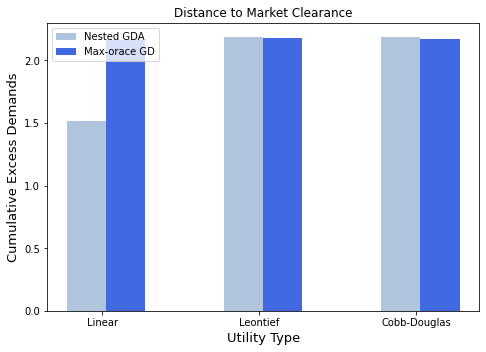

In [ ]:
data = [[1.51360722680293, 2.1885091150520655, 2.1892506104891303],
      [2.1650851972578646,2.178489762142351, 2.1697254289647336]]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Distance to Market Clearance')
ax.bar(X + 0.00, data[0], color = 'lightsteelblue', width = 0.25, label ='Nested GDA')
ax.bar(X + 0.25, data[1], color = 'royalblue', width = 0.25, label ='Max-orace GD')

plt.xlabel('Utility Type', fontsize = 13)
plt.xticks([r + 0.1 for r in range(3)],
        ['Linear', 'Leontief', 'Cobb-Douglas'])
plt.ylabel('Cumulative Excess Demands', fontsize = 13)


plt.legend()
plt.show()